In [1]:
%matplotlib inline
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
from data_tools import *
from data_tools import IOTools as it
from data_tools import PandasTools as pt
from data_tools import ChartTools as ct
from data_tools import ImageTools as imt
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
ct.IPYTHON_MODE = True
imt.IPYTHON_MODE = True
base_dir = 'E:\文档\dataset\dogs_vs_cats_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
# 图像加清晰函数


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Using TensorFlow backend.


#### 图片读取案例
* ImageTool读取图片
* keras Image读取图片


In [5]:
img_path = '%s\cats\cat.1700.jpg' % test_dir
img = imt.read_image(img_path).resize((150, 150))
img_tensor = imt.to_np_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = img_tensor / 255.
print(img_tensor.shape)

========== Image Info ==========
 format: JPEG 
 width/height: (324, 333) 
 mode: RGB
(1, 150, 150, 3)


In [5]:
from keras.preprocessing import image
img_path = '%s\cats\cat.1700.jpg' % test_dir
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


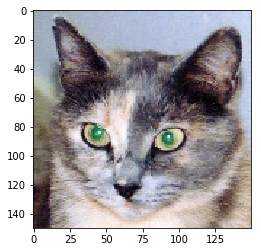

In [7]:
imt.show(img)

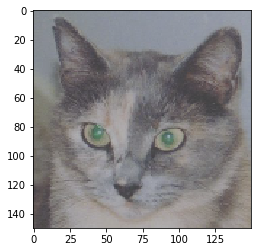

In [76]:
imt.show(deprocess_image(img_tensor[0, :, :, :]))

#### CNN训练可视化案例（卷积层输出）：
**步骤**：在CNN模型cats_and_dog_small_2.h5中，使用上述载入的一张图片，进行前向运算，显示最后8层的Feature Map

**结论**：整个过程相当于信息提炼过程，从最初的原数据，逐渐提炼出图片的细节，放大特有的特征，最后由这些特有特征来断定图片的类别，如同人们描述一类物体一样，都是先从其抽象描述至具体


In [8]:
from keras.models import load_model
model = load_model('models/cats_and_dog_small_2.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [9]:
# 获取模型前8层的输出结果
layer_outputs = [layer.output for layer in model.layers[:8]]
# 创建模型，建立输入为图片输出为8张feature map的模型
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13_input (InputLayer) (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
__________

In [10]:
# 对载入的图片进行预测
activations = activation_model.predict(img_tensor)

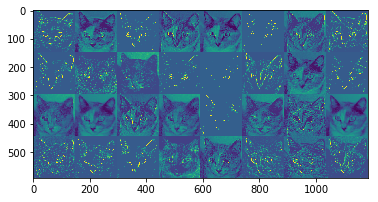

In [77]:
# 第一层卷积输出shape：1,148,148,32
# feature map中收集到了不同边界信息，包含了大量的原始信息
first_layer_activation = activations[0]
icb = imt.ImageCombiner((148 * 8, 148 * 4), mode='L')
k = 0
for i in range(4):
    for j in range(8):
        icb.append(imt.to_pil_image(deprocess_image(
            first_layer_activation[0, :, :, k] * 255)), (i, j))
        k += 1
imt.show(icb.finish())

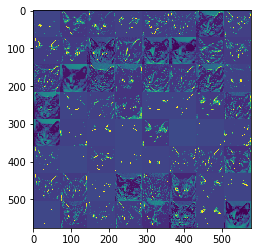

In [78]:
# 第二层卷积输出shape：1,72,72,64
# feature map中图像变得抽象，编码出一些高级特征（比如：眼睛、耳朵）
second_layer_activation = activations[2]
icb = imt.ImageCombiner((72 * 8, 72 * 8), mode='L')
k = 0
for i in range(8):
    for j in range(8):
        icb.append(imt.to_pil_image(deprocess_image(
            second_layer_activation[0, :, :, k] * 255)), (i, j))
        k += 1
imt.show(icb.finish())

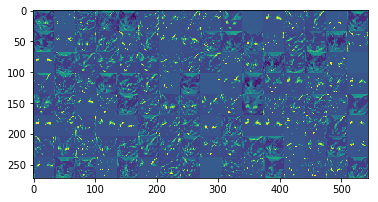

In [79]:
# 第三层卷积输出shape： 1,34, 34, 128
# feature map中图像变得更抽象，编码出一些特殊的轮廓特征
layer_activation = activations[4]
icb = imt.ImageCombiner((34 * 16, 34 * 8), mode='L')
k = 0
for i in range(8):
    for j in range(16):
        icb.append(imt.to_pil_image(deprocess_image(
            layer_activation[0, :, :, k] * 255)), (i, j))
        k += 1
imt.show(icb.finish())

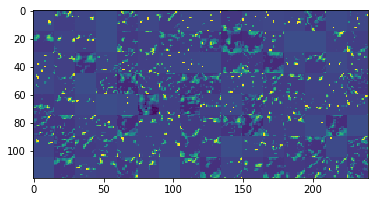

In [71]:
# 第4层卷积输出shape： 1,15, 15, 128
layer_activation = activations[6]
icb = imt.ImageCombiner((15 * 16, 15 * 8), mode='L')
k = 0
for i in range(8):
    for j in range(16):
        icb.append(imt.to_pil_image(deprocess_image(
            layer_activation[0, :, :, k] * 255)), (i, j))
        k += 1
imt.show(icb.finish())

#### CNN训练可视化案例（卷积过滤器）：
1. 生成一张随机图作为输入图片
2. 使用VGG16中的某层卷积输出求损失值
3. 使用计算出的损失值对输入图片求梯度
4. 画出进行梯度上升后的输入图片

**目的：** 观察卷积过滤器对输入图片的影响

**结论：** 卷积过滤器将原图进行了分解，类似于傅里叶变换将信号处理成多个余弦函数，随着卷积层数变高图像分解变得越来越精细复杂


In [64]:
from keras.applications import VGG16
from keras import backend as K
model = VGG16(weights='imagenet',
              include_top=False, input_shape=(150, 150, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [61]:
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])
grads = K.gradients(loss, model.input)[0]
# 对梯度除以它的L2范式，用于平滑、正则化梯度，使其对输入tensor的下降在相同范围内，防止梯度爆炸
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
# 注册函数iterate，根据模型输入求vgg16中block3_conv1的损失值、梯度值
iterate = K.function([model.input], [loss, grads])
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [68]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]
    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

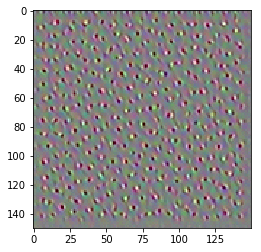

In [82]:
# 一张随机图
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
# 画出block3_conv1中第256的卷积核对图片的影响
imt.show(generate_pattern('block3_conv1', 255))

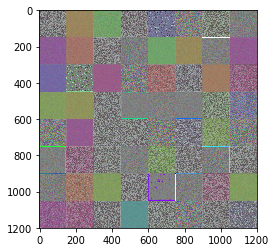

In [88]:
# 画出block1_conv1中64个卷积核对图片的影响
icb = imt.ImageCombiner((150 * 8, 150 * 8))
k = 0
for i in range(8):
    for j in range(8):
        icb.append(imt.to_pil_image(
            generate_pattern('block1_conv1', k)), (i, j))
        k += 1
imt.show(icb.finish())

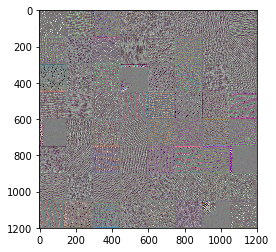

In [89]:
icb = imt.ImageCombiner((150 * 8, 150 * 8))
k = 0
for i in range(8):
    for j in range(8):
        icb.append(imt.to_pil_image(
            generate_pattern('block3_conv1', k)), (i, j))
        k += 1
imt.show(icb.finish())

#### CNN训练可视化案例（分类热点图）
Class Activation Map (CAM)： 通过建立热点图来确定图像中哪些特征对分类起到关键作用

**步骤：**
1. 使用VGG16模型的最后一个卷积层的输出来观察整个模型预测判断的重点区域
2. 对所要检测的图像做预处理，如调整大小，增加维度，转化类型适应VGG16模型的输入
3. 建立热力图生成函数
4. 使用opencv对热力图平滑放大，并叠加至原图中生成CAM图像

In [31]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [83]:
from keras import backend as K
def get_heatmap(input_img, max_prop_index):
    # 获取预测值最大的分类输出
    output = model.output[:, max_prop_index]
    # 获取VGG16最后一个卷积层
    last_conv_layer = model.get_layer('block5_conv3')
    # 使用分类输出对最后一层卷积求梯度
    grads = K.gradients(output, last_conv_layer.output)[0]
    # This is a vector of shape (512,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `block5_conv3`,
    # given a sample image
    iterate = K.function(
        [model.input], [pooled_grads, last_conv_layer.output[0]])
    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image of two elephants
    pooled_grads_value, conv_layer_output_value = iterate([input_img])
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the elephant class
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    return heatmap

========== Image Info ==========
 format: JPEG 
 width/height: (324, 333) 
 mode: RGB


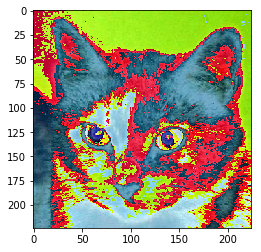

In [80]:
# 图片预处理
from keras.applications.vgg16 import preprocess_input
img = imt.read_image(img_path).resize((224, 224))
img_tensor = imt.to_np_array(img).astype(np.float64)
x = np.expand_dims(img_tensor, 0)
x=preprocess_input(x)
imt.show(x[0, :, :, :])

In [81]:
# 分类预测
from keras.applications.vgg16 import decode_predictions
preds = model.predict(x)
decode_predictions(preds, top=3)

[[('n02124075', 'Egyptian_cat', 0.52406168),
  ('n02119789', 'kit_fox', 0.1756224),
  ('n02120505', 'grey_fox', 0.06227183)]]

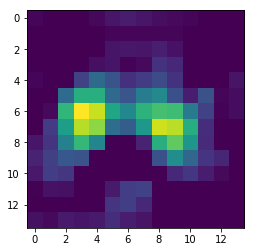

In [84]:
# 创建热力图
max_prop_index= np.argmax(preds)
heatmap= get_heatmap(x,max_prop_index)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
imt.show(heatmap)

========== Image Info ==========
 format: JPEG 
 width/height: (324, 333) 
 mode: RGB


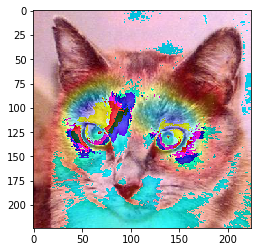

True

In [93]:
import cv2

img = imt.read_image(img_path).resize((224, 224))
img_tensor = imt.to_np_array(img)
# 对heatmap 重定义大小
heatmap_new = cv2.resize(heatmap, (img_tensor .shape[1], img_tensor.shape[0]))
# We convert the heatmap to RGB
heatmap_new = np.uint8(255 * heatmap_new)
# We apply the heatmap to the original image
heatmap_new = cv2.applyColorMap(heatmap_new, cv2.COLORMAP_JET)
# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap_new * 0.4 + img_tensor

imt.show(imt.to_pil_image(superimposed_img) )
cv2.imwrite('.\\superimposed_img.jpg', superimposed_img)